# Libraries and versions

In [1]:
python_version = !python -V #version 3.7.9
import pandas as pd #version 1.2.4
import numpy as np #version 1.20.1
import seaborn as sns #version 0.11.0
import matplotlib as plt #version 3.3.3
from datetime import date as dt

#Modelo
from sklearn.metrics import mean_squared_log_error, r2_score
from sklearn.linear_model import Ridge

#Visualização
from yellowbrick.regressor import PredictionError, ResidualsPlot

In [2]:
print(f'Python version - {python_version[0][7:]}')
print(f'Pandas version - {pd.__version__}')
print(f'Numpy version - {np.__version__}')
print(f'Seaborn version - {sns.__version__}')
print(f'Matplotlib version - {plt.__version__}')

Python version - 3.8.8
Pandas version - 1.2.4
Numpy version - 1.20.1
Seaborn version - 0.11.1
Matplotlib version - 3.3.4


# Configurations

## Pandas

In [3]:
#apresentará 500 colunas e linhas
pd.set_option('display.max_columns', 500)
pd.set_option('display.max_rows', 20)

## Seaborn

In [4]:
sns.set_palette('inferno')
sns.set_style('darkgrid')

def configuration(graphic_object, title=None, xlabel=None, ylabel=None, colors=None):
    graphic_object.figure.set_size_inches(20,8)
    graphic_object.set_title(title, color=colors, fontsize=16)
    graphic_object.set_xlabel(xlabel, color=colors, fontsize=14)
    graphic_object.set_ylabel(ylabel, color=colors, fontsize=14)
    graphic_object = graphic_object

## Warnings

In [5]:
import warnings
warnings.filterwarnings("ignore")

## Base

In [6]:
bvsp = pd.read_csv('bvsp_modelado_original.csv')
bvsp.head()

,data,abertura,alta,baixa,fechamento,var_abertura,media_movel_180,media_movel_240,media_movel_360,media_movel_480
0,1995-02-27,3217.399902,3345.800049,3184.399902,3270.899902,0.000000,4404.944448,3785.654587,2719.633892,2057.587711
1,1995-02-28,3217.399902,3345.800049,3184.399902,3270.899902,0.000000,4404.830560,3792.938337,2728.090837,2064.238961
2,1995-03-01,3217.399902,3345.800049,3184.399902,3270.899902,0.000000,4404.943892,3800.340836,2736.526114,2070.890836
3,1995-03-02,3270.899902,3270.899902,2970.199951,2989.100098,53.500000,4405.345558,3807.966252,2745.099169,2077.654585
4,1995-03-03,2989.100098,3018.100098,2841.699951,2988.000000,-281.799804,4404.507225,3814.417502,2752.882781,2083.832502


### Informações

In [7]:
bvsp.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6637 entries, 0 to 6636
Data columns (total 10 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   data             6637 non-null   object 
 1   abertura         6637 non-null   float64
 2   alta             6637 non-null   float64
 3   baixa            6637 non-null   float64
 4   fechamento       6637 non-null   float64
 5   var_abertura     6637 non-null   float64
 6   media_movel_180  6637 non-null   float64
 7   media_movel_240  6637 non-null   float64
 8   media_movel_360  6637 non-null   float64
 9   media_movel_480  6637 non-null   float64
dtypes: float64(9), object(1)
memory usage: 518.6+ KB


### Transformar índice em data

In [8]:
#transforma coluna em data
bvsp['data'] = pd.to_datetime(bvsp['data'])

#transforma o índice em data
bvsp.set_index('data', inplace=True)

### Função do modelo

In [25]:
def ridge(dados_treino, dados_validacao, exclui_colunas, target, iteracoes):
    #dados de treino
    X_treino = dados_treino.drop(columns=list(exclui_colunas))
    y_treino = dados_treino[target]
    
    #dados de validacao
    X_validacao = dados_validacao.drop(columns=list(exclui_colunas))
    y_validacao = dados_validacao[target]
    
    #iterações para o modelo
    lista_erro = []
    lista_r2 = []
    for i in range(iteracoes):
        #instancia o modelo
        global modelo
        modelo = Ridge()

        #treino e validação
        modelo.fit(X_treino, y_treino)
        y_previsao = modelo.predict(X_validacao)

        #extrai os indicadores
        erro = mean_squared_log_error(y_validacao, y_previsao)
        r2 = r2_score(y_validacao, y_previsao)

        #salva indicadores na lista
        lista_erro.append(erro)
        lista_r2.append(r2)

    #cria arrays para extrair os resultados
    ar_erro = np.asarray(lista_erro)
    ar_r2 = np.asarray(lista_r2)

    print(f'ERRO MÉDIO QUADRÁTICO EM {iteracoes} ITERACOES')
    print(f'Média = {ar_erro.mean():.5f}\nDesvio Padrão = {ar_erro.std():.5f}')
    print(f'Intervalo - {ar_erro.mean() - (2*ar_erro.std()):.5f} / {ar_erro.mean() + (2*ar_erro.std()):.5f}')
    print(f'Máximo = {ar_erro.max():.5f}\nMínimo = {ar_erro.min():.5f}')
    print('')
    print(f'R2 EM {iteracoes} ITERAÇÕES')
    print(f'Média = {ar_r2.mean():.3f}\nDesvio Padrão = {ar_r2.std():.3f}')
    print(f'Intervalo - {ar_r2.mean() - (2*ar_r2.std()):.4f} / {ar_r2.mean() + (2*ar_r2.std()):.4f}')
    print(f'Máximo = {ar_r2.max():.3f}\nMínimo = {ar_r2.min():.3f}')
    print('='*80)
    print('GRÁFICOS'.center(80))
    print('='*80)
    
    #plotar gráfico R2
    residuos = ResidualsPlot(Ridge())
    residuos.fit(X_treino, y_treino)
    residuos.score(X_validacao, y_validacao)
    residuos.show()
    
    #plotar gráfico Erro
    erro_previsto = PredictionError(Ridge())
    erro_previsto.fit(X_treino, y_treino)
    erro_previsto.score(X_validacao, y_validacao)
    erro_previsto.show()
    
    return residuos.show(), erro_previsto.show()

### Separar dados de treino e validação

In [26]:
dt_treino = bvsp.loc[:'2020-05-29']
dt_validacao = bvsp.loc['2020-06-01':]

### Fechamento

ERRO MÉDIO QUADRÁTICO EM 100 ITERACOES
Média = 0.00020
Desvio Padrão = 0.00000
Intervalo - 0.00020 / 0.00020
Máximo = 0.00020
Mínimo = 0.00020

R2 EM 100 ITERAÇÕES
Média = 0.976
Desvio Padrão = 0.000
Intervalo - 0.9755 / 0.9756
Máximo = 0.976
Mínimo = 0.975
                                    GRÁFICOS                                    


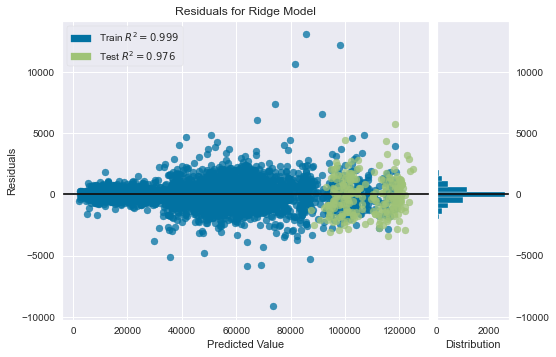

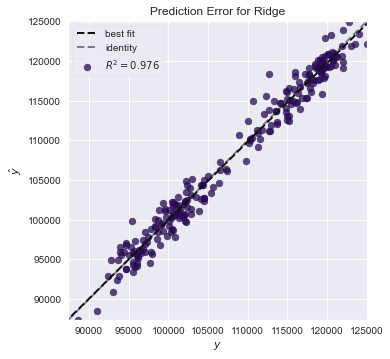

(<AxesSubplot:title={'center':'Residuals for Ridge Model'}, xlabel='Predicted Value', ylabel='Residuals'>,
 <AxesSubplot:title={'center':'Prediction Error for Ridge'}, xlabel='$y$', ylabel='$\\hat{y}$'>)

In [27]:
ridge(dt_treino, dt_validacao, exclui_colunas=['alta', 'baixa', 'fechamento'], target='fechamento', iteracoes=100)

### Baixa

ERRO MÉDIO QUADRÁTICO EM 100 ITERACOES
Média = 0.00010
Desvio Padrão = 0.00000
Intervalo - 0.00010 / 0.00010
Máximo = 0.00010
Mínimo = 0.00010

R2 EM 100 ITERAÇÕES
Média = 0.987
Desvio Padrão = 0.000
Intervalo - 0.9873 / 0.9873
Máximo = 0.987
Mínimo = 0.987
                                    GRÁFICOS                                    


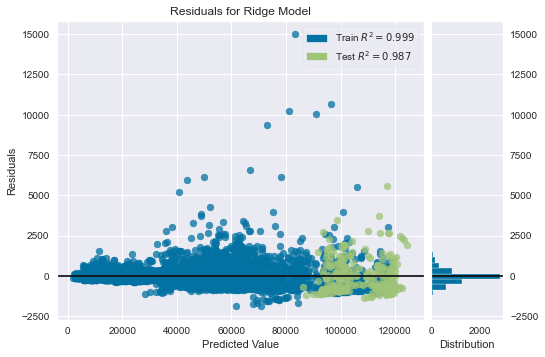

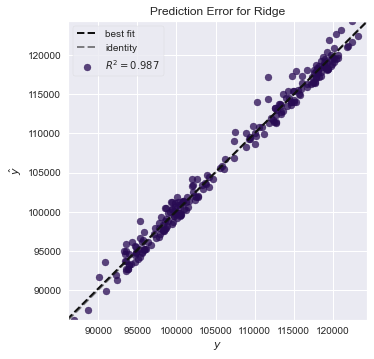

(<AxesSubplot:title={'center':'Residuals for Ridge Model'}, xlabel='Predicted Value', ylabel='Residuals'>,
 <AxesSubplot:title={'center':'Prediction Error for Ridge'}, xlabel='$y$', ylabel='$\\hat{y}$'>)

In [12]:
ridge(dt_treino, dt_validacao, exclui_colunas=['alta', 'baixa', 'fechamento'], target='baixa', iteracoes=100)

### Alta

ERRO MÉDIO QUADRÁTICO EM 100 ITERACOES
Média = 0.00007
Desvio Padrão = 0.00000
Intervalo - 0.00007 / 0.00007
Máximo = 0.00007
Mínimo = 0.00007

R2 EM 100 ITERAÇÕES
Média = 0.991
Desvio Padrão = 0.000
Intervalo - 0.9911 / 0.9911
Máximo = 0.991
Mínimo = 0.991
                                    GRÁFICOS                                    


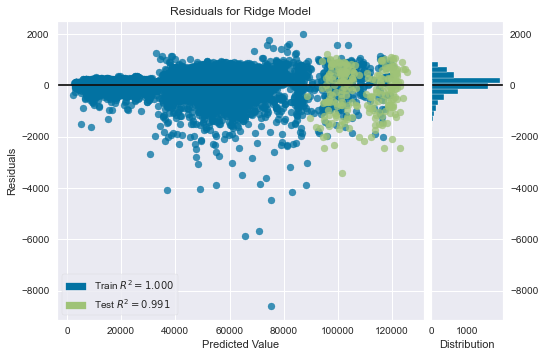

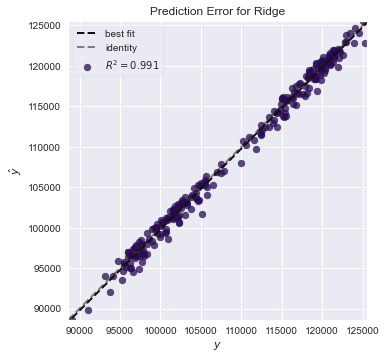

(<AxesSubplot:title={'center':'Residuals for Ridge Model'}, xlabel='Predicted Value', ylabel='Residuals'>,
 <AxesSubplot:title={'center':'Prediction Error for Ridge'}, xlabel='$y$', ylabel='$\\hat{y}$'>)

In [13]:
ridge(dt_treino, dt_validacao, exclui_colunas=['alta', 'baixa', 'fechamento'], target='alta', iteracoes=100)

### Conclusões

LGBM não é um bom regressor pois não é um regressor linear, apresentado resultados piores que o Lasso

**Estudar modelo e trabalhar hiperparâmetros**

0.001